In [ ]:
import os
import urllib.request
import zipfile
import tarfile

def download_file(url, save_path):
    # 파일 다운로드
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        urllib.request.urlretrieve(url, save_path)
        print(f"{os.path.basename(save_path)} download complete.")

def extract_zip(zip_path, extract_to):
    # ZIP 파일 압축 해제
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print(f"Extracting {os.path.basename(zip_path)}...")
        zip_ref.extractall(extract_to)
        print(f"{os.path.basename(zip_path)} extraction complete.")

def extract_tar(tar_path, extract_to):
    # TAR 파일 압축 해제
    with tarfile.open(tar_path, 'r') as tar_ref:
        print(f"Extracting {os.path.basename(tar_path)}...")
        tar_ref.extractall(extract_to)
        print(f"{os.path.basename(tar_path)} extraction complete.")

# 1. Caltech 101 데이터셋 URL 및 디렉토리 설정
dataset_url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
base_dir = "./caltech_101"  # 최상위 폴더
zip_filename = "caltech-101.zip"
zip_path = os.path.join(base_dir, zip_filename)

# 2. ZIP 다운로드 및 압축 해제
os.makedirs(base_dir, exist_ok=True)
download_file(dataset_url, zip_path)
extract_zip(zip_path, base_dir)

# 3. ZIP 내부의 폴더 경로 (`./caltech_101/caltech-101/`)
inner_dir = os.path.join(base_dir, "caltech-101")

# 4. ZIP 내부의 TAR 파일들 압축 해제
object_categories_tar = os.path.join(inner_dir, "101_ObjectCategories.tar.gz")
annotations_tar = os.path.join(inner_dir, "Annotations.tar")

# 5. 압축 해제할 위치 지정 (최상위 `caltech_101` 폴더로 설정)
extract_tar(object_categories_tar, base_dir)
extract_tar(annotations_tar, base_dir)

caltech-101.zip download complete.
Extracting caltech-101.zip...
caltech-101.zip extraction complete.
Extracting 101_ObjectCategories.tar.gz...
101_ObjectCategories.tar.gz extraction complete.
Extracting Annotations.tar...
Annotations.tar extraction complete.


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch

class Caltech101Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        """
        Caltech-101 데이터셋 클래스 (폴더 구조 기반 라벨링)

        Args:
            img_dir (str): 이미지가 저장된 최상위 디렉토리.
            transform (callable, optional): 이미지에 적용할 변환 함수.
            target_transform (callable, optional): 라벨에 적용할 변환 함수.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_labels = self._load_labels()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_file, label = self.img_labels.iloc[idx]
        img_path = os.path.join(self.img_dir, img_file)
        image = read_image(img_path)

        # 변환 적용
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def _load_labels(self):
        """
        폴더 구조를 탐색하여 이미지 파일과 클래스 라벨을 DataFrame으로 변환.
        """
        img_files = []
        labels = []
        class_to_idx = {}  # 클래스명 → 인덱스 매핑
        categories = sorted(os.listdir(self.img_dir))  # 클래스 폴더 정렬

        for idx, category in enumerate(categories):
            category_path = os.path.join(self.img_dir, category)
            if os.path.isdir(category_path):
                class_to_idx[category] = idx  # 클래스 매핑
                for img_name in os.listdir(category_path):
                    if img_name.endswith((".jpg", ".png")):  # 이미지 파일만 선택
                        img_files.append(os.path.join(category, img_name))
                        labels.append(idx)

        # 라벨이 0부터 시작하도록 조정
        labels_df = pd.DataFrame({"file_name": img_files, "class_id": labels})
        labels_df["class_id"] -= labels_df["class_id"].min()  # 최소값을 0으로 설정
        return labels_df


# 데이터 디렉토리 설정
img_dir = "./caltech_101/101_ObjectCategories"

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 전체 데이터셋 초기화
full_dataset = Caltech101Dataset(img_dir, transform=transform)

# Train/Val/Test 데이터셋 분할 (7:1:2 비율)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 샘플 데이터 확인
for images, labels in train_dataloader:
    print(f"Train batch - Images shape: {images.shape}, Labels: {labels}")
    break

for images, labels in val_dataloader:
    print(f"Validation batch - Images shape: {images.shape}, Labels: {labels}")
    break

for images, labels in test_dataloader:
    print(f"Test batch - Images shape: {images.shape}, Labels: {labels}")
    break

Train dataset size: 6400
Validation dataset size: 914
Test dataset size: 1830
Train dataset size: 6400
Validation dataset size: 914
Test dataset size: 1830
Train batch - Images shape: torch.Size([16, 3, 128, 128]), Labels: tensor([ 6, 66,  0, 59, 16,  1, 41, 47,  1,  0,  0, 92,  0,  6, 30, 37])
Validation batch - Images shape: torch.Size([16, 3, 128, 128]), Labels: tensor([ 6, 15, 26, 90,  4, 77, 87, 14,  6, 93, 91, 16, 91, 74, 76,  6])
Test batch - Images shape: torch.Size([16, 3, 128, 128]), Labels: tensor([ 6,  4, 95, 56,  0, 97, 52, 41, 83, 64, 70,  6, 73, 74, 97, 56])


In [ ]:
# 클래스 ID 범위 확인
all_labels = full_dataset.img_labels["class_id"].unique()
print(f"Unique class labels: {sorted(all_labels)}")
print(f"Total unique classes: {len(all_labels)}")


Unique class labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
Total unique classes: 102


In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * BasicBlock.expansion)

        self.activation = nn.ReLU()

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.skip(x)
        out = self.activation(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, block, num_classes=102):
        super(ResNet18, self).__init__()
        torch.manual_seed(2024)

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, 2, stride=1)
        self.layer2 = self.make_layer(block, 128, 2, stride=2)
        self.layer3 = self.make_layer(block, 256, 2, stride=2)
        self.layer4 = self.make_layer(block, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.affine = nn.Linear(512 * block.expansion, num_classes)

        self.activation = nn.ReLU()

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_channels, out_channels, strides[i]))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.affine(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(BasicBlock, num_classes=102).to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20], gamma=0.1)  # learning rate decay
criterion = nn.CrossEntropyLoss()


Total parameters: 11221222


Epoch [1/40]
  Train Loss: 4.4793, Train Acc: 0.1284
  Val Loss: 4.1702, Val Acc: 0.1389
Epoch [2/40]
  Train Loss: 3.9561, Train Acc: 0.1625
  Val Loss: 3.8602, Val Acc: 0.1937
Epoch [3/40]
  Train Loss: 3.7104, Train Acc: 0.2031
  Val Loss: 3.5480, Val Acc: 0.2166
Epoch [4/40]
  Train Loss: 3.5007, Train Acc: 0.2420
  Val Loss: 3.3921, Val Acc: 0.2495
Epoch [5/40]
  Train Loss: 3.3779, Train Acc: 0.2695
  Val Loss: 3.3388, Val Acc: 0.2856
Epoch [6/40]
  Train Loss: 3.2319, Train Acc: 0.3025
  Val Loss: 3.1466, Val Acc: 0.3129
Epoch [7/40]
  Train Loss: 3.1372, Train Acc: 0.3222
  Val Loss: 3.4723, Val Acc: 0.3118
Epoch [8/40]
  Train Loss: 3.0290, Train Acc: 0.3322
  Val Loss: 2.9047, Val Acc: 0.3611
Epoch [9/40]
  Train Loss: 2.9167, Train Acc: 0.3542
  Val Loss: 2.8064, Val Acc: 0.3654
Epoch [10/40]
  Train Loss: 2.7998, Train Acc: 0.3698
  Val Loss: 2.7284, Val Acc: 0.3972
Epoch [11/40]
  Train Loss: 2.6891, Train Acc: 0.3844
  Val Loss: 2.6372, Val Acc: 0.4136
Epoch [12/40]
  Tra

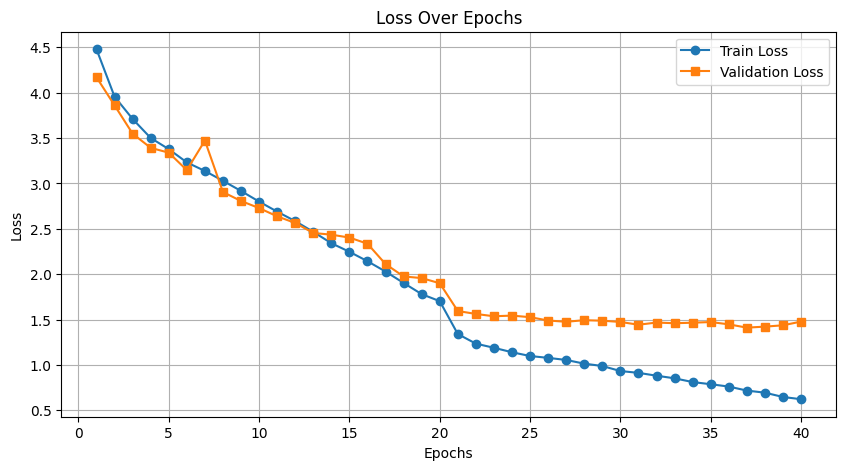

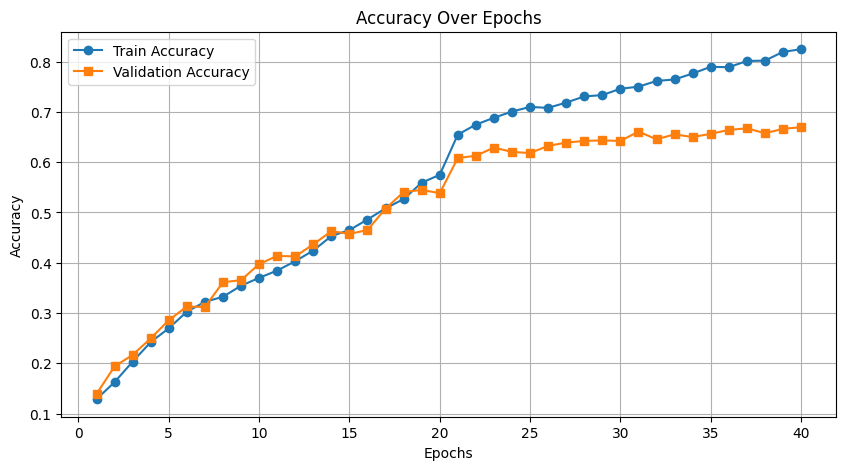

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 학습 함수
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device).long()  # labels를 int64로 변환
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total  # 평균 Loss, Accuracy 반환

# 검증 함수
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).long()  # labels를 int64로 변환
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total  # 평균 Loss, Accuracy 반환

# 학습 루프
num_epochs = 40
best_val_acc = 0.0

# 결과 저장을 위한 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion, device)

    # 스케줄러 업데이트
    train_scheduler.step()

    # 결과 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # 검증 정확도 업데이트
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")  # 최고 모델 저장

    # 학습 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# 학습 및 검증 결과 시각화
epochs = range(1, num_epochs + 1)

# Loss 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import torch

# 모델 로드
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

# 테스트 정확도 계산 함수
def test_model(model, dataloader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    return test_accuracy

# 테스트 정확도 출력
test_acc = test_model(model, test_dataloader, device)
print(f"Test Accuracy: {test_acc:.4f}")

<ipython-input-11-b54892867e32>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 0.6601


In [ ]:
import torch
import torch.nn as nn

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        squeeze = self.global_avg_pool(x).view(b, c)
        excitation = self.fc(squeeze).view(b, c, 1, 1)
        return x * excitation

class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SEBasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels * SEBasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * SEBasicBlock.expansion)

        self.se = SELayer(out_channels * SEBasicBlock.expansion, reduction)

        self.activation = nn.ReLU()

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != SEBasicBlock.expansion * out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * SEBasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * SEBasicBlock.expansion)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se(out)

        out += self.skip(x)
        out = self.activation(out)

        return out

class SeNet18(nn.Module):
    def __init__(self, block, num_classes=102, reduction=16):
        super(SeNet18, self).__init__()
        torch.manual_seed(2024)

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, 2, stride=1, reduction=reduction)
        self.layer2 = self.make_layer(block, 128, 2, stride=2, reduction=reduction)
        self.layer3 = self.make_layer(block, 256, 2, stride=2, reduction=reduction)
        self.layer4 = self.make_layer(block, 512, 2, stride=2, reduction=reduction)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.affine = nn.Linear(512 * block.expansion, num_classes)

        self.activation = nn.ReLU()

    def make_layer(self, block, out_channels, num_blocks, stride, reduction):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_channels, out_channels, strides[i], reduction))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.affine(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senet = SeNet18(SEBasicBlock, num_classes=102).to(device)

print(f"Total parameters: {sum(p.numel() for p in senet.parameters())}")

learning_rate = 0.1
optimizer = torch.optim.SGD(senet.parameters(), lr=learning_rate, momentum=0.9)
train_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20], gamma=0.1)  # learning rate decay
criterion = nn.CrossEntropyLoss()

Total parameters: 11308262


Epoch [1/40]
  Train Loss: 4.1979, Train Acc: 0.1625
  Val Loss: 3.6500, Val Acc: 0.2199
Epoch [2/40]
  Train Loss: 3.5811, Train Acc: 0.2270
  Val Loss: 3.4524, Val Acc: 0.2484
Epoch [3/40]
  Train Loss: 3.4112, Train Acc: 0.2608
  Val Loss: 3.2224, Val Acc: 0.2954
Epoch [4/40]
  Train Loss: 3.2478, Train Acc: 0.2944
  Val Loss: 3.0963, Val Acc: 0.3326
Epoch [5/40]
  Train Loss: 3.0976, Train Acc: 0.3172
  Val Loss: 3.0183, Val Acc: 0.3228
Epoch [6/40]
  Train Loss: 3.0136, Train Acc: 0.3286
  Val Loss: 3.0311, Val Acc: 0.3337
Epoch [7/40]
  Train Loss: 2.9125, Train Acc: 0.3517
  Val Loss: 2.8560, Val Acc: 0.3742
Epoch [8/40]
  Train Loss: 2.8210, Train Acc: 0.3638
  Val Loss: 2.7483, Val Acc: 0.3643
Epoch [9/40]
  Train Loss: 2.7403, Train Acc: 0.3750
  Val Loss: 2.6909, Val Acc: 0.3982
Epoch [10/40]
  Train Loss: 2.6481, Train Acc: 0.3855
  Val Loss: 2.6314, Val Acc: 0.4256
Epoch [11/40]
  Train Loss: 2.5369, Train Acc: 0.4080
  Val Loss: 2.5342, Val Acc: 0.4256
Epoch [12/40]
  Tra

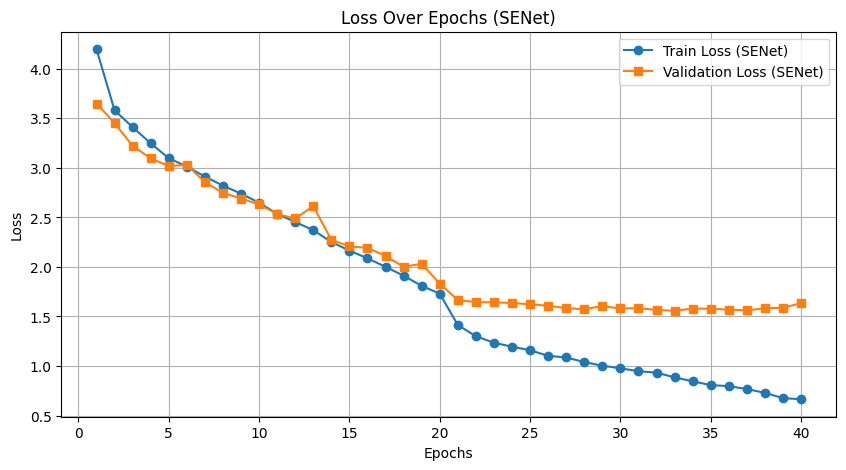

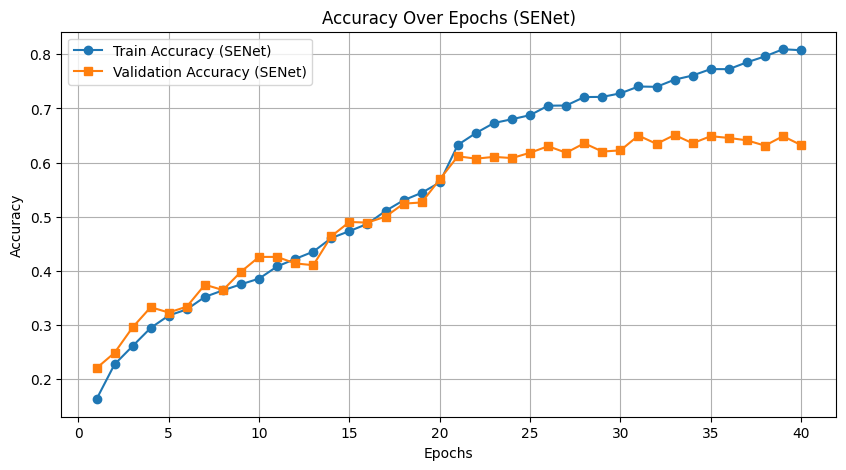

In [ ]:
best_val_acc = 0

# 결과 저장을 위한 리스트
train_losses_senet = []
val_losses_senet = []
train_accuracies_senet = []
val_accuracies_senet = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(senet, train_dataloader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(senet, val_dataloader, criterion, device)

    # 스케줄러 업데이트
    train_scheduler.step()

    # 결과 저장
    train_losses_senet.append(train_loss)
    val_losses_senet.append(val_loss)
    train_accuracies_senet.append(train_acc)
    val_accuracies_senet.append(val_acc)

    # 검증 정확도 업데이트
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(senet.state_dict(), "best_senet_model.pth")  # 최고 모델 저장

    # 학습 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# 학습 및 검증 결과 시각화
epochs = range(1, num_epochs + 1)

# Loss 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_senet, label='Train Loss (SENet)', marker='o')
plt.plot(epochs, val_losses_senet, label='Validation Loss (SENet)', marker='s')
plt.title('Loss Over Epochs (SENet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies_senet, label='Train Accuracy (SENet)', marker='o')
plt.plot(epochs, val_accuracies_senet, label='Validation Accuracy (SENet)', marker='s')
plt.title('Accuracy Over Epochs (SENet)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 모델 로드
senet.load_state_dict(torch.load("best_senet_model.pth"))
senet.to(device)
senet.eval()

# 테스트 정확도 계산 함수
def test_model(model, dataloader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    return test_accuracy

# SENet 모델 테스트 정확도 출력
test_acc_senet = test_model(senet, test_dataloader, device)
print(f"SENet Test Accuracy: {test_acc_senet:.4f}")

<ipython-input-14-e0de6be5eac5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  senet.load_state_dict(torch.load("best_senet_model.pth"))


SENet Test Accuracy: 0.6322


# **Caltech-101 Dataset 개요**  

### **주요 특징**  

#### **이미지 크기**  
- 다양한 크기의 이미지로 제공되며, **RGB 컬러 이미지**로 구성되어 있습니다.  
- 각 이미지의 **해상도는 고정되어 있지 않으며**, 다양한 크기와 비율로 제공됩니다.

#### **클래스 수**  
- 총 **101개 객체 클래스** + **1개 배경 클래스**로 구성되어 있습니다.  
- 각 클래스는 **40~800개 이미지**를 포함하고 있으며, **평균적으로 약 50개의 이미지**가 존재합니다.  

#### **데이터 분할**  
- 총 **9,146개의 이미지**가 포함되어 있습니다.  
- 특정한 공식 분할이 제공되지 않으므로, 연구 목적에 따라 **임의로 데이터를 분할**해야 합니다.  
- 현재 실험에서는 Train, Val, Test 비율을 0.7, 0.1, 0.2로 사용하였습니다.

#### **이미지 특징**  
- **정확하게 정렬된 객체 중심 이미지**로 구성되어 있으며, 대부분의 객체는 **비교적 명확하게 분리**되어 있습니다.  
- **다양한 배경, 조명, 크기 변형**이 포함되어 있지만, **배경이 복잡하지 않은 경우가 많아** 비교적 간단한 객체 인식 문제에 적합합니다.
- 객체의 **위치, 스케일, 조명**이 변형된 다양한 데이터가 포함되어 있습니다.

#### **활용 분야**  
- **Object Classification**


**Caltech-101**은 비교적 간단한 데이터셋으로, 다양한 **딥러닝 모델의 성능 평가 및 비교**에 자주 활용됩니다.


# **데이터 전처리**

Caltech-101 Dataset을 모델 학습에 적합하도록 변환하기 위해 다음과 같은 데이터 전처리를 수행합니다:

1. **PIL 이미지 변환**
   - PyTorch의 `read_image`로 로드된 이미지는 텐서 형식입니다.
   - 이를 `transforms.ToPILImage()`를 사용해 PIL 이미지로 변환합니다.
  - Resize와 RGB 변환이 PIL 이미지에서만 지원되기 때문에, 이러한 변환을 수행합니다.

2. **이미지 크기 조정 (Resize)**  
   - 이미지는 다양한 크기로 제공되므로, 모델 입력에 맞춰 **128x128 크기로 조정**합니다.

3. **RGB 변환**  
   - 일부 흑백 이미지가 포함되어 있을 수 있으므로, `transforms.Lambda(lambda img: img.convert("RGB"))`를 사용해 **3채널(RGB)**로 변환합니다.

4. **텐서 변환 (ToTensor)**  
   - PIL 이미지를 PyTorch 텐서로 변환하여 모델 학습에 사용합니다.
   - 변환된 텐서는 `[C, H, W]` 형식 (채널, 높이, 너비)을 가집니다.

5. **정규화 (Normalize)**  
   - 각 픽셀 값을 평균(mean) 0.5, 표준편차(std) 0.5로 정규화하여 **[-1, 1] 범위**로 변환합니다.
   - 정규화는 학습 안정성과 모델 수렴 속도를 높이는 데 도움을 줍니다.

# **분석 및 고찰**

### 1. **모델 학습 결과**
**두 모델 모두** 학습 초반에는 손실 값이 빠르게 감소하고 정확도가 점진적으로 증가하며, 모델이 효과적으로 학습하고 있음을 보여주었습니다. 25epoch까지 훈련 및 검증 데이터에서 성능이 지속적으로 향상되었으나, 이후부터는 검증 데이터에서의 성능 개선이 둔화되기 시작했습니다. 30epoch 이후에는  Val Loss와 Train Loss의 격차가 점점 벌어지며 **오버피팅** 징후가 보이기 시작했습니다.

### 2. **모델 및 하이퍼파라미터 설정**
#### 강점
- **ResNet18 아키텍처 활용:** BasicBlock을 사용해 깊은 네트워크를 구성. 잔차 연결로 인해 그래디언트 소실 문제를 효과적으로 해결했습니다.
- **Dropout 추가:** Fully Connected Layer에 Dropout을 추가하여 일부 과적합 문제를 완화했습니다.
- **Learning Rate Decay:** Epoch 20에서 학습률 감소를 적용하여 학습 안정화했습니다.
- **SELayer**: SeNet-18에 대해서만 SELayer를 통해 채널별 중요도를 추가 학습했습니다.

### 3. **결론**
- **동일한 하이퍼 파라미터 설정과 ResNet-18 구조에 SeLayer만 추가하여 학습**을 진행하였지만, 오히려 test accuracy에 대해선 **SeNet-18**이 63%로 ResNet-18보다 **3%가 더 낮게** 나온 것을 볼 수 있습니다. 채널별 중요도를 하나의 샘플에 대해 학습하는 과정에서 기대했던 성능 향상이 나타나지 않았습니다. SELayer의 효과를 극대화 하기 위해선 **추가적인 적절한 하이퍼 파라미터 조정일 필요**할 것으로 보입니다.